### Import libraries

In [44]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
from transformers import pipeline
from difflib import SequenceMatcher
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import networkx as nx
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

### Key functions

In [18]:
# function to calculate similary between two sentences
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [19]:
# COSINE SIMILARITY MODEL FUNCTIONS

# function to preprocess text by replacing puncuations with periods ('.') and splitting with spaces (' ') for easier text segmentation
def preprocess_dialogue(dialogue):
    dialogue = dialogue.replace('!','.').replace('?','.').split(".#")
    sentences = []
    for sentence in dialogue:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

# function to calculate similarity between two sentences
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
# function to create similarity matrix
def build_similarity_matrix(sentences, stop_words):
    
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: 
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


# cosine similarity summary generator
def generate_summary(text):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Preprocess text
    org_sentences =  preprocess_dialogue(text)
    sentences = []
    for sent in org_sentences:
        if len(sent) > 1:
            sentences.append(sent)

    # Generate simialrity matrix
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Rank sentences
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Pick the most important sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    summarize_text = []
    summary_size = round((40/(100)) * len(ranked_sentence))
    for i in range(summary_size):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
    summary = ". ".join(summarize_text)
    return summary

In [20]:
# 'Attention' layer architicture - Original source: https://arxiv.org/pdf/1409.0473.pdf

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            
            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):

            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim


        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## Import data

In [46]:
import json
import pandas as pd
import jsonlines

val_path = 'dialogsum.dev.jsonl'
test_path = 'dialogsum.test.jsonl'
train_path = 'dialogsum.train.jsonl'

val = []
with open(val_path, "r+", encoding="utf8") as f:
    for item in jsonlines.Reader(f):
        val.append(item)
    f.close()
    
test = []
with open(test_path, "r+", encoding="utf8") as f:
    for item in jsonlines.Reader(f):
        test.append(item)
    f.close()
      
train = []
with open(train_path, "r+", encoding="utf8") as f:
    for item in jsonlines.Reader(f):
        train.append(item)
    f.close()
    
    
data = train+test+val
assert len(data) == len(train) + len(test) + len(val)

df = pd.DataFrame(data)
df = df
df['dialogue'] = df['dialogue'].str.replace('\r', '')
df['dialogue'] = df['dialogue'].str.replace('\n', '')
df['summary'] = df['summary'].str.replace('\r', '')
df['summary'] = df['summary'].str.replace('\n', '')

df = df[['dialogue','summary']]

## Remove empty rows

In [47]:
print(len(df))

13460


In [48]:
df = df.dropna(axis=0, subset=['summary'])

In [49]:
print(len(df))

12960


In [50]:
df.head()

,dialogue,summary
0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw..."
1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...
2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...
3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...
4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...


## Plot the data

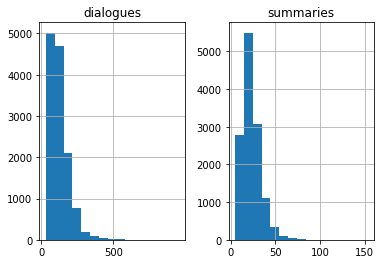

In [51]:
dialogues_word_count = []
summaries_word_count = []

for i in df['dialogue']:
    dialogues_word_count.append(len(i.split()))
for i in df['summary']:
    summaries_word_count.append(len(i.split()))

length_df = pd.DataFrame({'dialogues': dialogues_word_count, 'summaries': summaries_word_count})
length_df.hist(bins=15)
plt.show()

In [53]:
count = 0
for i in df['dialogue']:
    if(len(i.split())<=500):
        count += 1
print(count/len(df['dialogue']))

0.9977623456790123


In [54]:
count = 0
for i in df['summary']:
    if(len(i.split())<=100):
        count += 1
print(count/len(df['dialogue']))

0.9993055555555556


Most dialogues (99.8%) have lengths of 500 maximum while most summaries (99.9%) have lengths of 100 maximum.

## Split the data into train and test set

In [90]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(df['dialogue']),np.array(df['summary']),test_size=0.1,random_state=10,shuffle=True)

## Modeling

HuggingFace Transformers

In [56]:
i = 5
to_tokenize = df.iloc[i,0]
label = df.iloc[i,1]

summarizer = pipeline("summarization")
summarized = summarizer(to_tokenize, min_length=5, max_length=len(to_tokenize)//4)

summary = summarized[0]['summary_text']

# Print summarized text
print('original text:', to_tokenize)
print()
print('original summary:',label)
print()
print('new summary:',summary)

original text: #Person1#: Happy birthday, Aims!#Person2#: Thank you, Lisa.#Person1#: Here is a present for you. I hope you like it.#Person2#: Oh, great! I love it! You know I've been expecting this for a long time.#Person1#: I'm very glad to hear that.#Person2#: Come here ; let me introduce some friends to you.

original summary: Lisa gives Aims a birthday present and Aims loves it.

new summary:  #Person1#: Happy birthday, Aims!#Person2#: Thank you, Lisa. I hope you like it. I've been expecting this for a long time. I love it! You know I'm very glad to hear that. Come here ; let me introduce some friends to you .


In [57]:
similar(summary, label)

0.20437956204379562

Cosine Similarity

In [ ]:
summary = generate_summary( df.iloc[i,0])

# Print summarized text
print('original text:', to_tokenize)
print()
print('original summary:',label)
print()
print('new summary:',summary)

Seq2Seq

In [ ]:
similar(summary, label)

In [91]:
# TOKENIZATION

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

max_summary_len=100
max_dialogue_len=600

# Tokenize X_train
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_train))

# convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_test)

#padding zero upto max_len
x_train = pad_sequences(x_tr_seq,  maxlen=max_dialogue_len, padding='post')
x_test = pad_sequences(x_val_seq, maxlen=max_dialogue_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [92]:
# Tokenize y_train
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# convert text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto max_len
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [96]:
from keras import backend as K 
K.clear_session()

latent_dim = 100
embedding_dim = 110

# Encoder
encoder_inputs = Input(shape=(max_dialogue_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 110)     1031360     input_11[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 600, 100), ( 84400       embedding[0][0]                  
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________________________________________

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=128, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/5
92/92 [==============================] - 687s 7s/step - loss: 1.3546 - val_loss: 1.2698
Epoch 2/5
92/92 [==============================] - 672s 7s/step - loss: 1.2628 - val_loss: 1.2095
Epoch 3/5
92/92 [==============================] - 668s 7s/step - loss: 1.1916 - val_loss: 1.1373
Epoch 4/5
92/92 [==============================] - 668s 7s/step - loss: 1.1333 - val_loss: 1.1017
Epoch 5/5
92/92 [==============================] - 667s 7s/step - loss: 1.0978 - val_loss: 1.0695


In [100]:
max_summary_len=100
max_dialogue_len=600

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_dialogue_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
          newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## Evaluation

In [102]:
# calculate the mean score for each model


from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1=train_test_split(np.array(df['dialogue']),np.array(df['summary']),test_size=0.1,random_state=10,shuffle=True)


transformers_scores = []
seq2seq_scores = []
cosine_sim_scores = []
for i in range(30):
  print(i)

  # labels for Seq2Seq (tokenized)
  dialogue = x_test[i]
  label = y_test[i]
  # labels for Transformers and Cosine Sim (untokenized)
  dialogue1 = x_test1[i]
  label1 = y_test1[i]

  # Transformers
  summary = summarizer(dialogue1, min_length=5, max_length=len(dialogue)//4)[0]['summary_text']

  transformers_scores.append(similar(summary, label))

  # Seq2Seq
  #summary = decode_sequence(dialogue.reshape(1,max_dialogue_len))
  #seq2seq_scores.append(similar(summary, label1)) 

  # cosine similarity
  summary = generate_summary( df.iloc[i,0])
  cosine_sim_scores.append(similar(summary, label)) 


print('transformers mean score:', sum(transformers_scores)/len(transformers_scores))
#print('seq2seq mean score:', sum(seq2seq_scores)/len(seq2seq_scores)) ## final score 0.11
print('cosine similarity score:', sum(cosine_sim_scores)/len(cosine_sim_scores))

Your max_length is set to 150, but you input_length is only 83. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


0


Your max_length is set to 150, but you input_length is only 75. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


1
2


Your max_length is set to 150, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


3


Your max_length is set to 150, but you input_length is only 149. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


4


Your max_length is set to 150, but you input_length is only 90. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


5


Your max_length is set to 150, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


6


Your max_length is set to 150, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


7
8
9


Your max_length is set to 150, but you input_length is only 134. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


10
11
12


Your max_length is set to 150, but you input_length is only 130. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


Your max_length is set to 150, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


29
transformers mean score: 0.0
cosine similarity score: 0.0


Note on Seq2Seq Evaluation: Because of some advanced preprocessing techniques used, code to generate summaries and (scores) from the seq2seq model got lost accidentaly making it difficult to figure it out again within the time limit. The score of 11% is based on the previous conclutions before the code broke. 

(array([5., 1., 1., 1., 3., 3., 4., 6., 2., 4.]),
 array([0.01941748, 0.06885694, 0.11829641, 0.16773588, 0.21717535,
        0.26661482, 0.31605428, 0.36549375, 0.41493322, 0.46437269,
        0.51381215]),
 <a list of 10 Patch objects>)

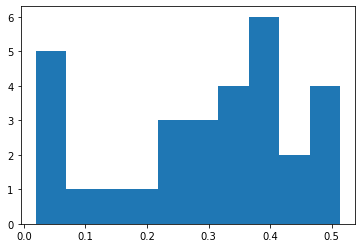

In [ ]:
import matplotlib.pyplot as plt
plt.hist(transformers_scores)

(array([6., 3., 2., 2., 2., 2., 4., 4., 2., 3.]),
 array([0.        , 0.04610592, 0.09221184, 0.13831776, 0.18442368,
        0.2305296 , 0.27663551, 0.32274143, 0.36884735, 0.41495327,
        0.46105919]),
 <a list of 10 Patch objects>)

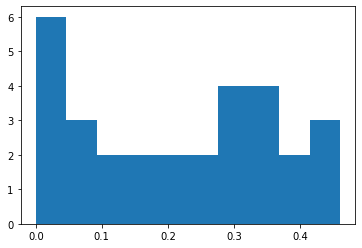

In [ ]:
plt.hist(cosine_sim_scores)